In [2]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np 

In [3]:
img_1st = cv2.imread('training/0/Training_3908.jpg')

In [4]:
img_1st.shape

(48, 48, 3)

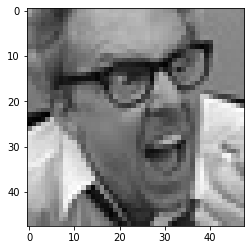

In [5]:
plt.imshow(img_1st)

# Testing For Working of Code

In [6]:
DataDir = 'training/'
Classes = ['0','1','2','3','4','5','6'] 

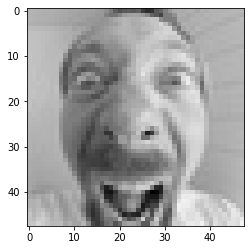

In [7]:
for category in Classes:
    path = os.path.join(DataDir, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))
        plt.show()
        break
    break

# Resizing the image for Transfer Learning

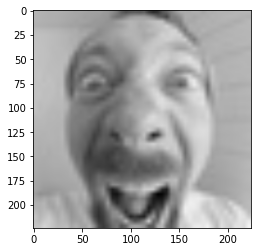

In [8]:
img_size = 224
new_array = cv2.resize(img_array, (img_size,img_size))
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
new_array.shape

(224, 224, 3)

# Reading all the images and converting them to Array

In [10]:
training_data = [] # it's a data array

def create_training_Data():
    for category in Classes:
        path = os.path.join(DataDir, category)
        class_num = Classes.index(category) 
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_array = cv2.resize(img_array, (img_size,img_size))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
            

In [11]:
create_training_Data()

In [12]:
print(len(training_data))

28709


In [13]:
temp = np.array(training_data)
temp.shape

/Users/mohammadazhar/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(28709, 2)

In [14]:
import random
random.shuffle(training_data)

# Making Features and Lables array

In [15]:
X = [] # features
y = [] # Labels

for features,label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1,img_size,img_size,3)


In [16]:
X.shape

(28709, 224, 224, 3)

In [17]:
# Normalize the data
X = X/255.0

In [18]:
y = np.array(y)

# Deep Learning Model For Training - Transfer Learning

In [19]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers

In [20]:
model = tf.keras.applications.MobileNetV2() # Pre-trained Model

2022-07-30 14:40:58.020569: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-30 14:40:58.023231: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [21]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

# Transfer Learning - Tuning will start from last checkpoint

In [22]:
base_input = model.layers[0].input # input
base_output = model.layers[-2].output

In [23]:
base_output

<tf.Tensor 'global_average_pooling2d/Identity:0' shape=(None, 1280) dtype=float32>

In [24]:
base_input

<tf.Tensor 'input_1:0' shape=(None, 224, 224, 3) dtype=float32>

In [25]:
final_output = layers.Dense(128)(base_output) #adding a new layer after the output
final_ouput = layers.Activation('relu')(final_output) # activation function
final_output = layers.Dense(64)(final_ouput)
final_ouput = layers.Activation('relu')(final_output)
final_output = layers.Dense(7,activation='softmax')(final_ouput) # my classes are 7

In [26]:
final_output

<tf.Tensor 'dense_2/Identity:0' shape=(None, 7) dtype=float32>

In [27]:
new_model = keras.Model(inputs = base_input, outputs = final_output)

In [28]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [29]:
new_model.compile(loss='sparse_categorical_crossentropy',optimizer = 'adam', metrics= ['accuracy'])

# Training Dataset

In [ ]:
new_model.fit(X,y,epochs=25)

In [ ]:
new_model.save('final_model.h5')